In [1]:
import torch, shap, glob, os
import numpy as np

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
# train val data path, checkpoint config
model_type = 'mlp'
version_type = 'ver2'
convet_index_dict = {'ver1': 'Integer', 'ver2': 'EIIP', 'ver3': 'Atomic', 'ver4': 'Voss'}
if model_type == 'cnn':
    npy_path = f'./np_image_totalunit/tsne-binary-perplexity=5-pixel=100[{convet_index_dict[version_type]}]/'
    save_weight_path = f'./model/weights_res18_tsne-binary-perplexity=50-pixel=100[{convet_index_dict[version_type]}]/'
    npy_data_list = [os.path.join(npy_path,'image_npy',i ) for i in sorted(os.listdir(os.path.join(npy_path,'image_npy')))]
else:
    npy_path = f'./np_image_totalunit/mlp_{convet_index_dict[version_type]}/'
    save_weight_path =f'./model/weights_mlp-binary-[{convet_index_dict[version_type]}]/'
    npy_data_list = np.load(f'./np_image_totalunit/mlp_{convet_index_dict[version_type]}/gene.npy')
if not os.path.exists(save_weight_path):
    os.mkdir(save_weight_path)

weights_name = f"weights_binaryclass_Covid19[-NACGT].2022.06.02-2-{convet_index_dict[version_type]}.pt"
path2weights = os.path.join(save_weight_path,weights_name)
label_ = np.load(os.path.join(npy_path,'label.npy'))

# split train, val data
X_train, X_test, y_train, y_test = train_test_split(npy_data_list, label_,stratify = label_, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,stratify = y_train, test_size=0.15, random_state=42)
print('train: ', len(X_train), '|| val: ', len(X_val), '|| test: ', len(X_test)) 


train:  723 || val:  128 || test:  284


In [3]:
from function import torch_dataset_func
train_ld = torch_dataset_func(model_type = model_type)
train_ds = train_ld.get_TransferDataset(data_list= X_train, labels= y_train, batch_size = 32, shuffle = True)
val_ld = torch_dataset_func(model_type = model_type)
val_ds = val_ld.get_TransferDataset(data_list= X_val, labels= y_val, batch_size = 32, shuffle = False)
print(len(train_ds), len(val_ds))

23 4


In [4]:
from train_val import train_val_function
params_train={
    "num_epochs": 200,
    "optimizer": 'Adam',
    "loss_func": 'BCE',
    "train_dl": train_ds,
    "val_dl": val_ds,
    "sanity_check": False,
    "lr_scheduler":  'ReduceLROnPlateau',
    "path2weights": path2weights,
    }

start_train = train_val_function()
if model_type !='cnn':
    start_train.model_config(model_type = model_type, data_shape = X_train.shape, class_num = 1, use_cuda = True)
else:
    start_train.model_config(model_type = model_type, data_shape = None, class_num = 1, use_cuda = True)

In [5]:
# start_train.get_model()

In [6]:
loss_history, metric_history, auc_history = start_train.train_val_main(params_train)

Epoch 0/199, current lr=0.003
Copied best model weights!
train loss: 0.706616, dev loss: 0.695957,  train accuracy: 39.19,valid accuracy: 39.06
train auc: 62.46,valid auc: 73.29
----------
Epoch 1/199, current lr=0.003
Copied best model weights!
train loss: 0.680772, dev loss: 0.695881,  train accuracy: 39.56,valid accuracy: 39.06
train auc: 66.29,valid auc: 78.95
----------
Epoch 2/199, current lr=0.003
train loss: 0.677358, dev loss: 0.696143,  train accuracy: 39.37,valid accuracy: 39.06
train auc: 69.02,valid auc: 77.50
----------
Epoch 3/199, current lr=0.003
Copied best model weights!
train loss: 0.671956, dev loss: 0.694605,  train accuracy: 39.56,valid accuracy: 39.06
train auc: 70.53,valid auc: 57.57
----------
Epoch 4/199, current lr=0.003
train loss: 0.675651, dev loss: 0.725184,  train accuracy: 39.28,valid accuracy: 39.06
train auc: 75.43,valid auc: 70.23
----------
Epoch 5/199, current lr=0.003
Copied best model weights!
train loss: 0.670220, dev loss: 0.687989,  train acc

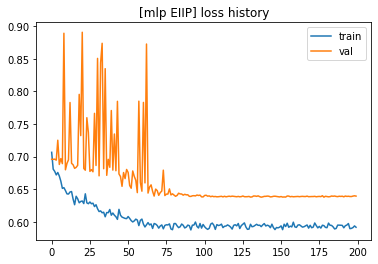

In [7]:
import matplotlib.pyplot as plt
plt.plot(loss_history['train'])
plt.plot(loss_history['val'])
plt.legend(['train','val'])
plt.title(f'[{model_type} {convet_index_dict[version_type]}] loss history')
plt.savefig(os.path.join(save_weight_path, f'{model_type }_{weights_name[0:-3]} - loss_history.jpg'))

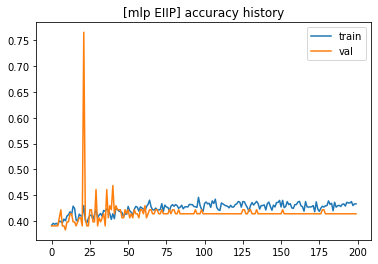

In [8]:
plt.plot(metric_history['train'])
plt.plot(metric_history['val'])
plt.legend(['train','val'])
plt.title(f'[{model_type} {convet_index_dict[version_type]}] accuracy history')
plt.savefig(os.path.join(save_weight_path, f'{model_type }_{weights_name[0:-3]} - accuracy_history.jpg'))

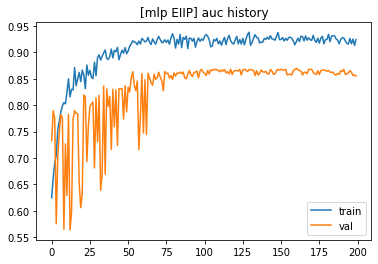

In [9]:
plt.plot(auc_history['train'])
plt.plot(auc_history['val'])
plt.legend(['train','val'])
plt.title(f'[{model_type} {convet_index_dict[version_type]}] auc history')
plt.savefig(os.path.join(save_weight_path, f'{model_type }_{weights_name[0:-3]} - auc_history.jpg'))
